In [1]:
import pandas as pd
import numpy as np
import cPickle as pickle
import matplotlib.pyplot as plt
% matplotlib inline

### Loading data

In [2]:

filepath = '/Users/Gevurtz/galvanize/beer_rec_project/beer-recommender/beer-recommender/data/states/aggregated.pkl'
with open(filepath, 'r') as f:
    data = pickle.load(f)

Converting json to pandas dataframe

In [3]:
df = pd.io.json.json_normalize(data)

In [4]:
# drop retired beers
df = df[df.breweryname != 'none']

### Dataframe info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2520704 entries, 0 to 2807668
Data columns (total 12 columns):
appearance     int64
aroma          int64
beerid         int64
beername       object
breweryname    object
overall        int64
palate         int64
style          object
taste          int64
text           object
userid         object
username       object
dtypes: int64(6), object(6)
memory usage: 250.0+ MB


In [6]:
df.head()

,appearance,aroma,beerid,beername,breweryname,overall,palate,style,taste,text,userid,username
0,3,6,256594,Singin River Handys Gold,Singin River Brewing Company,13,4,Golden Ale/Blond Ale,6,pours a medium golden yellowish color aromas o...,28586,oldrtybastrd
1,4,6,256594,Singin River Handys Gold,Singin River Brewing Company,12,3,Golden Ale/Blond Ale,6,can at home pours clear gold with a large pill...,9357,BeerandBlues2
2,4,6,256594,Singin River Handys Gold,Singin River Brewing Company,9,4,Golden Ale/Blond Ale,6,can slightly hazed goldsmall puffy white head ...,151324,Patrickctenchi
3,5,7,256594,Singin River Handys Gold,Singin River Brewing Company,10,2,Golden Ale/Blond Ale,5,can orange peach biscuit malt and straw aroma ...,10924,shrubber85
4,4,7,256594,Singin River Handys Gold,Singin River Brewing Company,15,4,Golden Ale/Blond Ale,7,poured from a 12 oz can into a pint glass the ...,327076,ordybill


### Summary statistics

In [7]:
def print_summary(df):
    n_beers = len(df.beerid.unique())
    n_breweries = len(df.breweryname.unique())
    n_styles = len(df.style.unique())
    n_users = len(df.userid.unique())
    n_reviews = len(df)

    print 'users:    ',n_users
    print 'reviews:  ',n_reviews
    print 'beers:    ', n_beers
    print 'breweries:', n_breweries
    print 'styles:   ', n_styles

In [8]:
print_summary(df)

users:     40579
reviews:   2520704
beers:     28588
breweries: 2491
styles:    79


In [ ]:
# are usernames a unique identifier?
len(df.username.unique())

## GraphLab modeling

In [9]:
import graphlab as gl

In [ ]:
df.columns

In [ ]:
df['userid'] = df['userid'].map(lambda x: int(x))
df['username'] = df['username'].map(lambda x: str(x))
#df['brewery_name'] = df['brewery_name'].map(lambda x: str(x))

In [10]:
SFdata = gl.SFrame(df)

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1477002498.log
INFO:graphlab.cython.cy_server:GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1477002498.log


This non-commercial license of GraphLab Create for academic use is assigned to gevurtz+galavize@gmail.com and will expire on October 17, 2017.


In [11]:
train, test = SFdata.random_split(.8, seed=1)

In [12]:
pop_model = gl.popularity_recommender.create(train, 'username', 'beerid', 'overall')

Recsys training: model = popularity

Warning: Ignoring columns appearance, aroma, beername, breweryname, palate, style, taste, text, userid;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 2016130 observations with 37440 users and 28588 items.

Data prepared in: 3.08428s

2016130 observations to process; with 28588 unique items.

In [13]:
baseline_rmse = gl.evaluation.rmse(test['overall'], pop_model.predict(test))
print 'Baseline RMSE: ',baseline_rmse

Baseline RMSE:  2.28360811749


In [15]:
baseline_rmse = gl.evaluation.rmse(train['overall'], pop_model.predict(train))
baseline_rmse

2.250207323725347

### Matrix Factorization Model with Side Features and Sub-reviews

In [16]:
obs_data_train = train['appearance',
                       'aroma',
                       'beerid',
                       'overall',
                       'palate',
                       'taste',
                      'username']
obs_data_test = test['appearance',
                       'aroma',
                       'beerid',
                       'overall',
                       'palate',
                       'taste',
                     'username']

In [22]:
obs_data_test

appearance,aroma,beerid,overall,palate,taste,username
4,6,256594,13,3,6,Itzjerm
5,5,256594,15,4,7,Aggiebob
3,6,256598,13,3,7,LiMuBai
4,5,256598,13,4,6,Aggiebob
5,6,403526,14,5,6,Patrickctenchi
5,7,403526,13,5,6,Aggiebob
3,6,403526,12,3,6,sonnycheeba
3,6,375884,14,3,6,crabbypantalones
3,6,375884,12,3,6,kerenmk
4,7,122302,14,3,7,TXBadger


In [17]:
product_data_train = train['beerid', 'style','breweryname']
product_data_test = test['beerid', 'style','breweryname']

In [18]:
regularization_vals = [.01, .001, .0001]

models = [gl.factorization_recommender.create(obs_data_train,
                                user_id="username",
                                item_id="beerid",
                                target="overall",
                                item_data=product_data_train,
                                max_iterations=50,
                                num_factors=5,
                                regularization=r)
                                              for r in regularization_vals]

Recsys training: model = factorization_recommender

Preparing data set.

Data has 2016130 observations with 37440 users and 28588 items.

Data prepared in: 6.04583s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 5        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 252016 / 2016130 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.00365459        | 2.35444                                  |

| 1       | 0.0018273         | 3.14429                                  |

| 2       | 0.000913649       | No Decrease (24.4922 >= 9.69869)         |

| 3       | 0.000228412       | No Decrease (11.5737 >= 9.69869)         |

+---------+-------------------+------------------------------------------+

| Final   | 0.00365459        | 2.35444                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 146us        | 9.70401           | 3.11512               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 2.06s        | 2.66703           | 1.6325                | 0.00365459  |

| 2       | 4.05s        | 2.23601           | 1.49533               | 0.00365459  |

| 3       | 6.01s        | 2.16851           | 1.47259               | 0.00365459  |

| 4       | 8.01s        | 2.12641           | 1.45822               | 0.00365459  |

| 5       | 10.01s       | 2.09503           | 1.44742               | 0.00365459  |

| 6       | 12.02s       | 2.07055           | 1.43894               | 0.00365459  |

| 7       | 13.98s       | 2.05037           | 1.43191               | 0.00365459  |

| 8       | 15.96s       | 2.03276           | 1.42575               | 0.00365459  |

| 9       | 18.37s       | 2.01717           | 1.42027               | 0.00365459  |

| 10      | 21.01s       | 2.00315           | 1.41533               | 0.00365459  |

| 11      | 23.61s       | 1.99058           | 1.41088               | 0.00365459  |

| 12      | 27.14s       | 1.979             | 1.40677               | 0.00365459  |

| 13      | 29.64s       | 1.96844           | 1.40301               | 0.00365459  |

| 14      | 32.09s       | 1.95853           | 1.39948               | 0.00365459  |

| 15      | 34.16s       | 1.94949           | 1.39624               | 0.00365459  |

| 16      | 36.19s       | 1.94099           | 1.39319               | 0.00365459  |

| 17      | 38.18s       | 1.93284           | 1.39027               | 0.00365459  |

| 18      | 40.18s       | 1.92561           | 1.38766               | 0.00365459  |

| 19      | 42.18s       | 1.91855           | 1.38512               | 0.00365459  |

| 20      | 44.16s       | 1.91176           | 1.38266               | 0.00365459  |

| 21      | 46.19s       | 1.90564           | 1.38045               | 0.00365459  |

| 22      | 48.21s       | 1.89965           | 1.37828               | 0.00365459  |

| 23      | 50.18s       | 1.89391           | 1.37619               | 0.00365459  |

| 24      | 52.18s       | 1.88857           | 1.37425               | 0.00365459  |

| 25      | 54.18s       | 1.88337           | 1.37236               | 0.00365459  |

| 26      | 56.17s       | 1.87848           | 1.37058               | 0.00365459  |

| 27      | 58.16s       | 1.8739            | 1.36891               | 0.00365459  |

| 28      | 1m 0s        | 1.86932           | 1.36723               | 0.00365459  |

| 29      | 1m 2s        | 1.86516           | 1.36571               | 0.00365459  |

| 30      | 1m 4s        | 1.86103           | 1.3642                | 0.00365459  |

| 31      | 1m 6s        | 1.85707           | 1.36274               | 0.00365459  |

| 32      | 1m 8s        | 1.85329           | 1.36136               | 0.00365459  |

| 33      | 1m 11s       | 1.84946           | 1.35995               | 0.00365459  |

| 34      | 1m 14s       | 1.84612           | 1.35872               | 0.00365459  |

| 35      | 1m 16s       | 1.84279           | 1.35749               | 0.00365459  |

| 36      | 1m 19s       | 1.83945           | 1.35626               | 0.00365459  |

| 37      | 1m 22s       | 1.83631           | 1.3551                | 0.00365459  |

| 38      | 1m 24s       | 1.83335           | 1.35401               | 0.00365459  |

| 39      | 1m 25s       | 1.83036           | 1.35291               | 0.00365459  |

| 40      | 1m 27s       | 1.82763           | 1.3519                | 0.00365459  |

| 41      | 1m 29s       | 1.82488           | 1.35088               | 0.00365459  |

| 42      | 1m 31s       | 1.82224           | 1.3499                | 0.00365459  |

| 43      | 1m 33s       | 1.81959           | 1.34892               | 0.00365459  |

| 44      | 1m 35s       | 1.81715           | 1.34802               | 0.00365459  |

| 45      | 1m 37s       | 1.81476           | 1.34713               | 0.00365459  |

| 46      | 1m 40s       | 1.81241           | 1.34626               | 0.00365459  |

| 47      | 1m 42s       | 1.81018           | 1.34543               | 0.00365459  |

| 48      | 1m 45s       | 1.80799           | 1.34461               | 0.00365459  |

| 49      | 1m 48s       | 1.8057            | 1.34376               | 0.00365459  |

| 50      | 1m 51s       | 1.80376           | 1.34304               | 0.00365459  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.8027

Final training RMSE: 1.34265

Recsys training: model = factorization_recommender

Preparing data set.

Data has 2016130 observations with 37440 users and 28588 items.

Data prepared in: 6.32115s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 5        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 252016 / 2016130 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0365459         | Not Viable                               |

| 1       | 0.00913649        | 2.52055                                  |

| 2       | 0.00456824        | Not Viable                               |

| 3       | 0.00114206        | Not Viable                               |

| 4       | 0.000285515       | No Decrease (19.1178 >= 9.75602)         |

+---------+-------------------+------------------------------------------+

| Final   | 0.00913649        | 2.52055                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 123us        | 9.70368           | 3.11507               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 2.55s        | 6.43908           | 2.53671               | 0.00913649  |

| 2       | 5.26s        | 2.09953           | 1.4477                | 0.00913649  |

| 3       | 7.32s        | 2.0086            | 1.4161                | 0.00913649  |

| 4       | 9.31s        | 1.95714           | 1.39794               | 0.00913649  |

| 5       | 11.31s       | 1.92265           | 1.38566               | 0.00913649  |

| 6       | 13.30s       | 1.89655           | 1.3763                | 0.00913649  |

| 7       | 15.29s       | 1.87682           | 1.36919               | 0.00913649  |

| 8       | 17.29s       | 1.86039           | 1.36323               | 0.00913649  |

| 9       | 19.27s       | 1.84624           | 1.35808               | 0.00913649  |

| 10      | 21.28s       | 1.83413           | 1.35366               | 0.00913649  |

| 11      | 23.30s       | 1.82334           | 1.34969               | 0.00913649  |

| 12      | 25.29s       | 1.81383           | 1.34619               | 0.00913649  |

| 13      | 27.30s       | 1.80513           | 1.34298               | 0.00913649  |

| 14      | 29.28s       | 1.79752           | 1.34015               | 0.00913649  |

| 15      | 31.29s       | 1.79038           | 1.3375                | 0.00913649  |

| 16      | 33.26s       | 1.78399           | 1.33511               | 0.00913649  |

| 17      | 35.26s       | 1.77794           | 1.33285               | 0.00913649  |

| 18      | 37.26s       | 1.77225           | 1.33072               | 0.00913649  |

| 19      | 39.20s       | 1.76759           | 1.32897               | 0.00913649  |

| 20      | 41.23s       | 1.7627            | 1.32714               | 0.00913649  |

| 21      | 43.23s       | 1.75826           | 1.32546               | 0.00913649  |

| 22      | 45.25s       | 1.75437           | 1.32399               | 0.00913649  |

| 23      | 47.23s       | 1.75057           | 1.32254               | 0.00913649  |

| 24      | 49.73s       | 1.74676           | 1.32111               | 0.00913649  |

| 25      | 52.28s       | 1.74347           | 1.31985               | 0.00913649  |

| 26      | 54.32s       | 1.74015           | 1.31859               | 0.00913649  |

| 27      | 56.36s       | 1.73681           | 1.31733               | 0.00913649  |

| 28      | 58.37s       | 1.73413           | 1.31631               | 0.00913649  |

| 29      | 1m 0s        | 1.73112           | 1.31517               | 0.00913649  |

| 30      | 1m 2s        | 1.72874           | 1.31427               | 0.00913649  |

| 31      | 1m 4s        | 1.72619           | 1.31331               | 0.00913649  |

| 32      | 1m 7s        | 1.72366           | 1.31235               | 0.00913649  |

| 33      | 1m 10s       | 1.72147           | 1.31154               | 0.00913649  |

| 34      | 1m 13s       | 1.71855           | 1.31044               | 0.00913649  |

| 35      | 1m 15s       | 1.7169            | 1.30981               | 0.00913649  |

| 36      | 1m 17s       | 1.71533           | 1.30926               | 0.00913649  |

| 37      | 1m 21s       | 1.71313           | 1.30845               | 0.00913649  |

| 38      | 1m 24s       | 1.71123           | 1.30775               | 0.00913649  |

| 39      | 1m 26s       | 1.70973           | 1.30721               | 0.00913649  |

| 40      | 1m 29s       | 1.70835           | 1.30673               | 0.00913649  |

| 41      | 1m 31s       | 1.70675           | 1.30617               | 0.00913649  |

| 42      | 1m 34s       | 1.70571           | 1.30582               | 0.00913649  |

| 43      | 1m 36s       | 1.70426           | 1.30531               | 0.00913649  |

| 44      | 1m 39s       | 1.70327           | 1.30498               | 0.00913649  |

| 45      | 1m 41s       | 1.70191           | 1.30448               | 0.00913649  |

| 46      | 1m 43s       | 1.70095           | 1.30412               | 0.00913649  |

| 47      | 1m 45s       | 1.69989           | 1.30369               | 0.00913649  |

| 48      | 1m 47s       | 1.69858           | 1.30312               | 0.00913649  |

| 49      | 1m 49s       | 1.69663           | 1.30228               | 0.00913649  |

| 50      | 1m 52s       | 1.69529           | 1.30165               | 0.00913649  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.69493

Final training RMSE: 1.30151

Recsys training: model = factorization_recommender

Preparing data set.

Data has 2016130 observations with 37440 users and 28588 items.

Data prepared in: 6.33711s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 5        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 252016 / 2016130 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.365459          | Not Viable                               |

| 1       | 0.0913649         | Not Viable                               |

| 2       | 0.0228412         | Not Viable                               |

| 3       | 0.0057103         | Not Viable                               |

| 4       | 0.00142758        | Not Viable                               |

| 5       | 0.000356894       | No Decrease (27.0033 >= 9.68896)         |

| 6       | 8.92235e-05       | 9.55192                                  |

| 7       | 4.46117e-05       | 9.3246                                   |

| 8       | 2.23059e-05       | 9.43828                                  |

| 9       | 1.11529e-05       | 9.54874                                  |

| 10      | 5.57647e-06       | 9.61445                                  |

+---------+-------------------+------------------------------------------+

| Final   | 4.46117e-05       | 9.3246                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 132us        | 9.70364           | 3.11507               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 3.08s        | 9.38809           | 3.06399               | 4.46117e-05 |

| 2       | 5.17s        | 9.38046           | 3.06275               | 4.46117e-05 |

| 3       | 7.25s        | 9.54726           | 3.08985               | 4.46117e-05 |

| 4       | 9.32s        | 9.7755            | 3.12656               | 4.46117e-05 |

| 5       | 11.46s       | 10.0445           | 3.16929               | 4.46117e-05 |

| 6       | 13.50s       | 10.3347           | 3.21475               | 4.46117e-05 |

| 7       | 15.55s       | 10.6558           | 3.26429               | 4.46117e-05 |

| 8       | 17.62s       | 10.9932           | 3.31558               | 4.46117e-05 |

| 9       | 20.38s       | DIVERGED          | DIVERGED              | 4.46117e-05 |

| RESET   | 21.17s       | 9.70388           | 3.11511               |             |

| 1       | 23.32s       | 9.4885            | 3.08034               | 2.23059e-05 |

| 2       | 25.41s       | 9.3726            | 3.06147               | 2.23059e-05 |

| 3       | 27.51s       | 9.33481           | 3.05529               | 2.23059e-05 |

| 4       | 29.62s       | 9.32324           | 3.05339               | 2.23059e-05 |

| 5       | 31.75s       | 9.32527           | 3.05373               | 2.23059e-05 |

| 6       | 33.89s       | 9.33216           | 3.05485               | 2.23059e-05 |

| 7       | 35.97s       | 9.35587           | 3.05873               | 2.23059e-05 |

| 8       | 38.02s       | 9.3867            | 3.06377               | 2.23059e-05 |

| 9       | 40.05s       | 9.42597           | 3.07017               | 2.23059e-05 |

| 10      | 42.01s       | 9.47391           | 3.07796               | 2.23059e-05 |

| 11      | 44.00s       | 9.52308           | 3.08594               | 2.23059e-05 |

| 12      | 45.97s       | 9.57851           | 3.0949                | 2.23059e-05 |

| 13      | 47.94s       | 9.63464           | 3.10396               | 2.23059e-05 |

| 14      | 49.90s       | 9.68339           | 3.1118                | 2.23059e-05 |

| 15      | 51.90s       | 9.7181            | 3.11737               | 2.23059e-05 |

| 16      | 53.86s       | 9.75337           | 3.12302               | 2.23059e-05 |

| 17      | 55.83s       | 9.78658           | 3.12834               | 2.23059e-05 |

| 18      | 57.78s       | 9.8263            | 3.13468               | 2.23059e-05 |

| 19      | 59.78s       | 9.86489           | 3.14083               | 2.23059e-05 |

| 20      | 1m 2s        | DIVERGED          | DIVERGED              | 2.23059e-05 |

| RESET   | 1m 3s        | 9.70166           | 3.11475               |             |

| 1       | 1m 5s        | 9.58879           | 3.09658               | 1.11529e-05 |

| 2       | 1m 7s        | 9.50795           | 3.0835                | 1.11529e-05 |

| 3       | 1m 9s        | 9.46259           | 3.07613               | 1.11529e-05 |

| 4       | 1m 11s       | 9.42893           | 3.07066               | 1.11529e-05 |

| 5       | 1m 13s       | 9.40219           | 3.0663                | 1.11529e-05 |

| 6       | 1m 15s       | 9.37842           | 3.06242               | 1.11529e-05 |

| 7       | 1m 17s       | 9.35986           | 3.05939               | 1.11529e-05 |

| 8       | 1m 19s       | 9.34728           | 3.05733               | 1.11529e-05 |

| 9       | 1m 21s       | 9.33646           | 3.05556               | 1.11529e-05 |

| 10      | 1m 23s       | 9.329             | 3.05434               | 1.11529e-05 |

| 11      | 1m 25s       | 9.32216           | 3.05322               | 1.11529e-05 |

| 12      | 1m 27s       | 9.31826           | 3.05258               | 1.11529e-05 |

| 13      | 1m 29s       | 9.31093           | 3.05138               | 1.11529e-05 |

| 14      | 1m 32s       | 9.30146           | 3.04983               | 1.11529e-05 |

| 15      | 1m 34s       | 9.29369           | 3.04855               | 1.11529e-05 |

| 16      | 1m 36s       | 9.2858            | 3.04726               | 1.11529e-05 |

| 17      | 1m 38s       | 9.27811           | 3.04599               | 1.11529e-05 |

| 18      | 1m 40s       | 9.27085           | 3.0448                | 1.11529e-05 |

| 19      | 1m 42s       | 9.26459           | 3.04377               | 1.11529e-05 |

| 20      | 1m 44s       | 9.25817           | 3.04272               | 1.11529e-05 |

| 21      | 1m 46s       | 9.25253           | 3.04179               | 1.11529e-05 |

| 22      | 1m 48s       | 9.24726           | 3.04093               | 1.11529e-05 |

| 23      | 1m 50s       | 9.24219           | 3.04009               | 1.11529e-05 |

| 24      | 1m 52s       | 9.23765           | 3.03934               | 1.11529e-05 |

| 25      | 1m 54s       | 9.23403           | 3.03875               | 1.11529e-05 |

| 26      | 1m 56s       | 9.23166           | 3.03836               | 1.11529e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached (hard limit).

Computing final objective value and training RMSE.

Final objective value: 9.23061

Final training RMSE: 3.03819

In [23]:
(rmse_train, rmse_test) = ([], [])
for m in models:
    rmse_train.append(m['training_rmse'])
    rmse_test.append(gl.evaluation.rmse(obs_data_test['overall'], m.predict(obs_data_test,
                                                                          new_item_data=product_data_test)))

In [24]:
new_test = test['overall', 'username', 'beerid']
(rmse_train, rmse_test) = ([], [])
for m in models:
    rmse_train.append(m['training_rmse'])
    rmse_test.append(gl.evaluation.rmse(obs_data_test['overall'], m.predict(obs_data_test,
                                                                          new_item_data=product_data_test)))

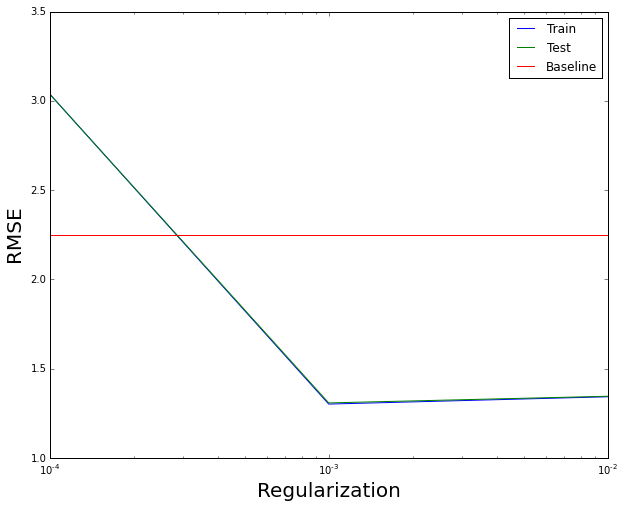

In [25]:
(fig, ax) = plt.subplots(figsize=(10, 8))
[p1, p2, p3] = ax.semilogx(regularization_vals, rmse_train, 
                           regularization_vals, rmse_test, 
                           regularization_vals, len(regularization_vals) * [baseline_rmse]
                           )
#ax.set_ylim([0.45, .7])
ax.set_xlabel('Regularization', fontsize=20)
ax.set_ylabel('RMSE', fontsize=20)
ax.legend([p1, p2, p3], ["Train", "Test", "Baseline"])
plt.show()

### Again, without subratings

In [26]:
obs_data_train = train['beerid',
                       'overall',
                      'username']
obs_data_test = test['beerid',
                       'overall',
                      'username']

In [27]:
product_data_train = train['beerid', 'style','breweryname']
product_data_test = test['beerid', 'style','breweryname']

In [28]:
regularization_vals = [.001, .0001, .00001]

new_models = [gl.factorization_recommender.create(obs_data_train,
                                user_id="username",
                                item_id="beerid",
                                target="overall",
                                item_data=product_data_train,
                                max_iterations=50,
                                num_factors=5,
                                regularization=r)
                                              for r in regularization_vals]

Recsys training: model = factorization_recommender

Preparing data set.

Data has 2016130 observations with 37440 users and 28588 items.

Data prepared in: 4.73642s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 5        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 252016 / 2016130 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0365459         | 4.98453                                  |

| 1       | 0.018273          | 5.54143                                  |

| 2       | 0.00913649        | 6.1053                                   |

| 3       | 0.00456824        | 6.70601                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0365459         | 4.98453                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 100us        | 9.70587           | 3.11542               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 1.24s        | 5.31502           | 2.30376               | 0.0365459   |

| 2       | 2.43s        | 4.85652           | 2.2006                | 0.0365459   |

| 3       | 4.04s        | 4.72144           | 2.17267               | 0.0365459   |

| 4       | 5.49s        | 4.65276           | 2.15693               | 0.0365459   |

| 5       | 6.90s        | 4.60139           | 2.14507               | 0.0365459   |

| 6       | 8.21s        | 4.56296           | 2.13609               | 0.0365459   |

| 7       | 9.75s        | 4.53512           | 2.12956               | 0.0365459   |

| 8       | 10.95s       | 4.51109           | 2.1239                | 0.0365459   |

| 9       | 12.12s       | 4.49217           | 2.11899               | 0.0365459   |

| 10      | 13.82s       | 4.47544           | 2.11496               | 0.0365459   |

| 11      | 15.21s       | 4.45575           | 2.11061               | 0.0365459   |

| 12      | 16.61s       | 4.44698           | 2.10849               | 0.0365459   |

| 13      | 18.02s       | 4.43606           | 2.10582               | 0.0365459   |

| 14      | 19.32s       | 4.42604           | 2.1036                | 0.0365459   |

| 15      | 20.51s       | 4.41653           | 2.10131               | 0.0365459   |

| 16      | 21.68s       | 4.40921           | 2.09956               | 0.0365459   |

| 17      | 22.83s       | 4.40497           | 2.09715               | 0.0365459   |

| 18      | 24.00s       | 4.39248           | 2.09521               | 0.0365459   |

| 19      | 25.18s       | 4.3885            | 2.09435               | 0.0365459   |

| 20      | 26.81s       | 4.38171           | 2.09298               | 0.0365459   |

| 21      | 28.39s       | 4.37739           | 2.09198               | 0.0365459   |

| 22      | 29.94s       | 4.36917           | 2.0901                | 0.0365459   |

| 23      | 31.78s       | 4.36744           | 2.08963               | 0.0365459   |

| 24      | 33.80s       | 4.36202           | 2.08826               | 0.0365459   |

| 25      | 35.22s       | 4.35825           | 2.08694               | 0.0365459   |

| 26      | 36.63s       | 4.35169           | 2.0854                | 0.0365459   |

| 27      | 38.07s       | 4.34984           | 2.08521               | 0.0365459   |

| 28      | 40.16s       | 4.34772           | 2.08468               | 0.0365459   |

| 29      | 41.55s       | 4.33978           | 2.08279               | 0.0365459   |

| 30      | 42.81s       | 4.34043           | 2.08286               | 0.0365459   |

| 31      | 44.19s       | 4.33579           | 2.08172               | 0.0365459   |

| 32      | 45.65s       | 4.33426           | 2.08133               | 0.0365459   |

| 33      | 47.04s       | 4.33064           | 2.0805                | 0.0365459   |

| 34      | 48.45s       | 4.32605           | 2.07952               | 0.0365459   |

| 35      | 50.44s       | 4.32615           | 2.07912               | 0.0365459   |

| 36      | 52.01s       | 4.31994           | 2.07775               | 0.0365459   |

| 37      | 53.50s       | 4.31881           | 2.07784               | 0.0365459   |

| 38      | 55.09s       | 4.3165            | 2.07727               | 0.0365459   |

| 39      | 56.53s       | 4.31604           | 2.07708               | 0.0365459   |

| 40      | 57.93s       | 4.30883           | 2.07549               | 0.0365459   |

| 41      | 59.17s       | 4.31082           | 2.0759                | 0.0365459   |

| 42      | 1m 0s        | 4.30881           | 2.07533               | 0.0365459   |

| 43      | 1m 1s        | 4.30936           | 2.07452               | 0.0365459   |

| 44      | 1m 3s        | 4.29778           | 2.07268               | 0.0365459   |

| 45      | 1m 4s        | 4.30269           | 2.07382               | 0.0365459   |

| 46      | 1m 5s        | 4.30017           | 2.07335               | 0.0365459   |

| 47      | 1m 7s        | 4.29892           | 2.07302               | 0.0365459   |

| 48      | 1m 9s        | 4.29737           | 2.07257               | 0.0365459   |

| 49      | 1m 10s       | 4.29568           | 2.07159               | 0.0365459   |

| 50      | 1m 12s       | 4.29207           | 2.07081               | 0.0365459   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 4.29561

Final training RMSE: 2.07167

Recsys training: model = factorization_recommender

Preparing data set.

Data has 2016130 observations with 37440 users and 28588 items.

Data prepared in: 4.53475s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 5        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 252016 / 2016130 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.365459          | 4.11757                                  |

| 1       | 0.18273           | 4.13411                                  |

| 2       | 0.0913649         | 4.06084                                  |

| 3       | 0.0456824         | 4.21883                                  |

| 4       | 0.0228412         | 4.5177                                   |

| 5       | 0.0114206         | 4.92612                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0913649         | 4.06084                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 116us        | 9.70563           | 3.11539               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 1.24s        | 4.74109           | 2.17275               | 0.0913649   |

| 2       | 2.39s        | 4.49107           | 2.09786               | 0.0913649   |

| 3       | 3.53s        | 4.37403           | 2.05701               | 0.0913649   |

| 4       | 4.70s        | 4.30689           | 2.03544               | 0.0913649   |

| 5       | 5.86s        | 4.26242           | 2.02111               | 0.0913649   |

| 6       | 7.01s        | 4.24258           | 2.01265               | 0.0913649   |

| 7       | 8.16s        | 4.22528           | 2.00471               | 0.0913649   |

| 8       | 9.32s        | 4.20777           | 1.99798               | 0.0913649   |

| 9       | 10.45s       | 4.18638           | 1.99093               | 0.0913649   |

| 10      | 11.62s       | 4.17498           | 1.98653               | 0.0913649   |

| 11      | 12.75s       | 4.15824           | 1.98122               | 0.0913649   |

| 12      | 13.90s       | 4.13866           | 1.97596               | 0.0913649   |

| 13      | 15.06s       | 4.13586           | 1.97419               | 0.0913649   |

| 14      | 16.20s       | 4.12538           | 1.97048               | 0.0913649   |

| 15      | 17.36s       | 4.12134           | 1.96812               | 0.0913649   |

| 16      | 18.48s       | 4.10966           | 1.96422               | 0.0913649   |

| 17      | 19.64s       | 4.10593           | 1.96231               | 0.0913649   |

| 18      | 20.81s       | 4.09821           | 1.95957               | 0.0913649   |

| 19      | 21.96s       | 4.07413           | 1.95391               | 0.0913649   |

| 20      | 23.12s       | 4.08789           | 1.95598               | 0.0913649   |

| 21      | 24.26s       | 4.06972           | 1.95135               | 0.0913649   |

| 22      | 25.48s       | 4.0657            | 1.94975               | 0.0913649   |

| 23      | 26.63s       | 4.06168           | 1.94835               | 0.0913649   |

| 24      | 27.81s       | 4.05513           | 1.9463                | 0.0913649   |

| 25      | 28.96s       | 4.05675           | 1.94581               | 0.0913649   |

| 26      | 30.10s       | 4.04961           | 1.94344               | 0.0913649   |

| 27      | 31.28s       | 4.04002           | 1.94087               | 0.0913649   |

| 28      | 32.45s       | 4.04279           | 1.94073               | 0.0913649   |

| 29      | 33.60s       | 4.04266           | 1.93997               | 0.0913649   |

| 30      | 34.77s       | 4.03225           | 1.93712               | 0.0913649   |

| 31      | 35.89s       | 4.02924           | 1.93603               | 0.0913649   |

| 32      | 37.15s       | 4.0252            | 1.93461               | 0.0913649   |

| 33      | 38.29s       | 4.02919           | 1.93456               | 0.0913649   |

| 34      | 39.43s       | 4.0208            | 1.93231               | 0.0913649   |

| 35      | 40.59s       | 4.02068           | 1.93174               | 0.0913649   |

| 36      | 41.73s       | 4.00825           | 1.92859               | 0.0913649   |

| 37      | 42.85s       | 4.01265           | 1.92924               | 0.0913649   |

| 38      | 44.00s       | 4.00545           | 1.92722               | 0.0913649   |

| 39      | 45.16s       | 4.00787           | 1.92728               | 0.0913649   |

| 40      | 46.30s       | 4.00765           | 1.92659               | 0.0913649   |

| 41      | 47.46s       | 3.99674           | 1.92385               | 0.0913649   |

| 42      | 48.62s       | 4.00063           | 1.92431               | 0.0913649   |

| 43      | 49.76s       | 4.00159           | 1.92384               | 0.0913649   |

| 44      | 50.91s       | 3.99773           | 1.92258               | 0.0913649   |

| 45      | 52.12s       | 3.99037           | 1.92061               | 0.0913649   |

| 46      | 53.26s       | 3.99133           | 1.92052               | 0.0913649   |

| 47      | 54.39s       | 3.98676           | 1.9191                | 0.0913649   |

| 48      | 55.54s       | 3.99044           | 1.9194                | 0.0913649   |

| 49      | 56.75s       | 3.98941           | 1.91865               | 0.0913649   |

| 50      | 57.88s       | 3.98067           | 1.91654               | 0.0913649   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.98725

Final training RMSE: 1.91826

Recsys training: model = factorization_recommender

Preparing data set.

Data has 2016130 observations with 37440 users and 28588 items.

Data prepared in: 3.57065s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 5        |

| regularization                 | L2 Regularization on Factors                     | 1e-05    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 252016 / 2016130 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 3.65459           | 4.30825                                  |

| 1       | 1.8273            | 3.1871                                   |

| 2       | 0.913649          | 2.71582                                  |

| 3       | 0.456824          | 2.66137                                  |

| 4       | 0.228412          | 2.81649                                  |

| 5       | 0.114206          | 3.20318                                  |

| 6       | 0.057103          | 3.63032                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.456824          | 2.66137                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 169us        | 9.70598           | 3.11544               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 1.19s        | 4.51443           | 2.11084               | 0.456824    |

| 2       | 2.36s        | 4.23028           | 2.00969               | 0.456824    |

| 3       | 3.56s        | 4.02852           | 1.93511               | 0.456824    |

| 4       | 4.73s        | 3.93147           | 1.89329               | 0.456824    |

| 5       | 5.89s        | 3.88011           | 1.86834               | 0.456824    |

| 6       | 7.04s        | 3.84312           | 1.85106               | 0.456824    |

| 7       | 8.20s        | 3.81181           | 1.83823               | 0.456824    |

| 8       | 9.40s        | 3.79592           | 1.82962               | 0.456824    |

| 9       | 10.56s       | 3.7802            | 1.82225               | 0.456824    |

| 10      | 11.72s       | 3.77501           | 1.81781               | 0.456824    |

| 11      | 12.88s       | 3.76              | 1.81206               | 0.456824    |

| 12      | 14.05s       | 3.75193           | 1.80857               | 0.456824    |

| 13      | 15.19s       | 3.74296           | 1.80531               | 0.456824    |

| 14      | 16.36s       | 3.71337           | 1.79893               | 0.456824    |

| 15      | 17.52s       | 3.72482           | 1.80041               | 0.456824    |

| 16      | 18.67s       | 3.70574           | 1.7964                | 0.456824    |

| 17      | 19.82s       | 3.70041           | 1.79495               | 0.456824    |

| 18      | 20.99s       | 3.69379           | 1.7936                | 0.456824    |

| 19      | 22.32s       | 3.68764           | 1.79235               | 0.456824    |

| 20      | 23.66s       | 3.68513           | 1.79139               | 0.456824    |

| 21      | 24.89s       | 3.67686           | 1.78955               | 0.456824    |

| 22      | 26.11s       | 3.66919           | 1.78831               | 0.456824    |

| 23      | 27.45s       | 3.6699            | 1.78813               | 0.456824    |

| 24      | 28.60s       | 3.66658           | 1.78751               | 0.456824    |

| 25      | 29.79s       | 3.6563            | 1.78558               | 0.456824    |

| 26      | 30.94s       | 3.65213           | 1.78492               | 0.456824    |

| 27      | 32.11s       | 3.64681           | 1.784                 | 0.456824    |

| 28      | 33.27s       | 3.64784           | 1.78388               | 0.456824    |

| 29      | 34.43s       | 3.64232           | 1.78316               | 0.456824    |

| 30      | 35.59s       | 3.63981           | 1.78276               | 0.456824    |

| 31      | 36.75s       | 3.62779           | 1.78052               | 0.456824    |

| 32      | 37.90s       | 3.63107           | 1.7816                | 0.456824    |

| 33      | 39.08s       | 3.62392           | 1.7804                | 0.456824    |

| 34      | 40.24s       | 3.62367           | 1.78034               | 0.456824    |

| 35      | 41.38s       | 3.62294           | 1.78027               | 0.456824    |

| 36      | 42.59s       | 3.61341           | 1.77864               | 0.456824    |

| 37      | 43.73s       | 3.6168            | 1.77958               | 0.456824    |

| 38      | 44.88s       | 3.61577           | 1.77923               | 0.456824    |

| 39      | 46.01s       | 3.61054           | 1.77837               | 0.456824    |

| 40      | 47.16s       | 3.60524           | 1.77747               | 0.456824    |

| 41      | 48.30s       | 3.60412           | 1.77744               | 0.456824    |

| 42      | 49.47s       | 3.59984           | 1.77668               | 0.456824    |

| 43      | 50.63s       | 3.60133           | 1.777                 | 0.456824    |

| 44      | 51.83s       | 3.60002           | 1.77676               | 0.456824    |

| 45      | 53.00s       | 3.59255           | 1.77567               | 0.456824    |

| 46      | 54.16s       | 3.59236           | 1.7759                | 0.456824    |

| 47      | 55.35s       | 3.59098           | 1.77551               | 0.456824    |

| 48      | 56.56s       | 3.59034           | 1.77574               | 0.456824    |

| 49      | 57.71s       | 3.58519           | 1.77471               | 0.456824    |

| 50      | 58.90s       | 3.58583           | 1.7749                | 0.456824    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.55829

Final training RMSE: 1.76712

In [ ]:
(rmse_train, rmse_test) = ([], [])
for m in new_models:
    rmse_train.append(m['training_rmse'])
    rmse_test.append(gl.evaluation.rmse(obs_data_test['overall'], m.predict(obs_data_test,
                                                                          new_item_data=product_data_test)))

In [ ]:
(fig, ax) = plt.subplots(figsize=(10, 8))
[p1, p2, p3] = ax.semilogx(regularization_vals, rmse_train, 
                           regularization_vals, rmse_test, 
                           regularization_vals, len(regularization_vals) * [baseline_rmse]
                           )
#ax.set_ylim([0.45, .7])
ax.set_xlabel('Regularization', fontsize=20)
ax.set_ylabel('RMSE', fontsize=20)
ax.legend([p1, p2, p3], ["Train", "Test", "Baseline"])
plt.show()

In [ ]:
new_models[2]

In [ ]:
best = new_models[2]

In [ ]:
best.get_similar_items()

In [ ]:
df[(df.beerid == 256594)]

In [ ]:
df[(df.beerid == 166019)]

In [ ]:
best.get_similar_items(items=[47130], k=10)

In [ ]:
best.recommend(users=['monty_pilsner'])